In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
ROOT = './data'
train_data = datasets.MNIST(
    root = ROOT,
    train = True,
    download = True
)
test_data = datasets.MNIST(
    root = ROOT,
    train = False,
    download = True
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:19<00:00, 517391.38it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 116926.80it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:08<00:00, 196907.40it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4554274.15it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [3]:
# split training : validation = 0.9 : 0.1
VALID_RATIO = 0.9
n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(
    train_data,
    [n_train_examples, n_valid_examples]
)

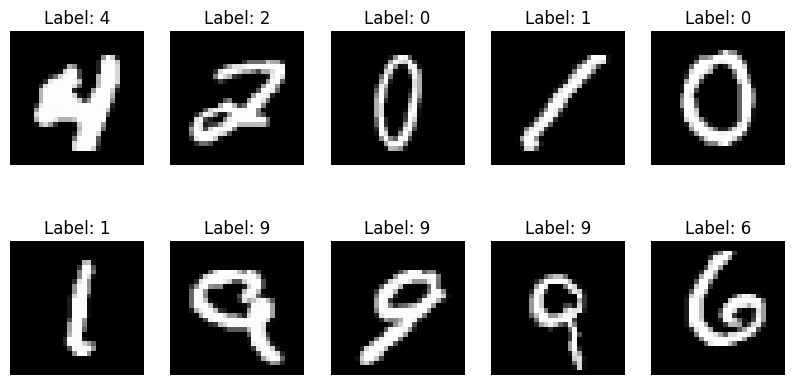

In [31]:
# visualize data
def visualize_random_data(data: torch.utils.data.Dataset):
    plt.figure(figsize=(10, 5))
    for i in range(10):
        random_index = random.randint(0, len(data) - 1)
        plt.subplot(2, 5, i + 1)
        plt.imshow(data[random_index][0], cmap='gray')
        plt.title(f'Label: {data[random_index][1]}')
        plt.axis('off')
    plt.show()

visualize_random_data(train_data)



In [49]:
# compute mean and std for normalization
mean = train_data.dataset.data.float().mean() / 255.0
std = train_data.dataset.data.float().std() / 255.0

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_data.dataset.transform = train_transform
valid_data.dataset.transform = valid_transform

In [67]:
BATCH_SIZE = 256

train_dataloader = data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE
)

valid_dataloader = data.DataLoader(
    valid_data,
    batch_size=BATCH_SIZE
)

In [84]:
class LeNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding='same'
        )
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(16 * 5 * 5, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, num_classes)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.avgpool1(outputs)
        outputs = F.relu(outputs)
        outputs = self.conv2(outputs)
        outputs = self.avgpool2(outputs)
        outputs = F.relu(outputs)
        outputs = self.flatten(outputs)
        outputs = self.fc_1(outputs)
        outputs = self.fc_2(outputs)
        outputs = self.fc_3(outputs)
        return outputs

In [93]:
# Training function
import time
def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    accs = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            accs.append(total_acc / total_count)
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = sum(accs) / len(accs)
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [94]:
def evaluate(model, criterion, valid_dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [97]:
# Train the model
num_classes = len(train_data.dataset.classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lenet_model = LeNetClassifier(num_classes)
lenet_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
learning_rate = 2e-4
optimizer = optim.Adam(lenet_model.parameters(), learning_rate)

num_epochs = 2
save_model = './model'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs + 1):
    epoch_start_time = time.time()
    # Training
    train_acc, train_loss = train(lenet_model, optimizer, criterion, train_dataloader,
                                 device, epoch, log_interval=10)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        torch.save(lenet_model.state_dict(), save_model + '/lenet_model.pt')

    # Print loss, acc end epoch
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc,
            eval_loss
        )
    )
    print("-" * 59)


| epoch   1 |    10/  211 batches | accuracy    0.195
| epoch   1 |    20/  211 batches | accuracy    0.360
| epoch   1 |    30/  211 batches | accuracy    0.421
| epoch   1 |    40/  211 batches | accuracy    0.494
| epoch   1 |    50/  211 batches | accuracy    0.518
| epoch   1 |    60/  211 batches | accuracy    0.636
| epoch   1 |    70/  211 batches | accuracy    0.723
| epoch   1 |    80/  211 batches | accuracy    0.768
| epoch   1 |    90/  211 batches | accuracy    0.779
| epoch   1 |   100/  211 batches | accuracy    0.798
| epoch   1 |   110/  211 batches | accuracy    0.812
| epoch   1 |   120/  211 batches | accuracy    0.816
| epoch   1 |   130/  211 batches | accuracy    0.827
| epoch   1 |   140/  211 batches | accuracy    0.836
| epoch   1 |   150/  211 batches | accuracy    0.848
| epoch   1 |   160/  211 batches | accuracy    0.850
| epoch   1 |   170/  211 batches | accuracy    0.855
| epoch   1 |   180/  211 batches | accuracy    0.860
| epoch   1 |   190/  211 ba